   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded
✅ Saved static heatmap grid
✅ Saved interactive heatmap


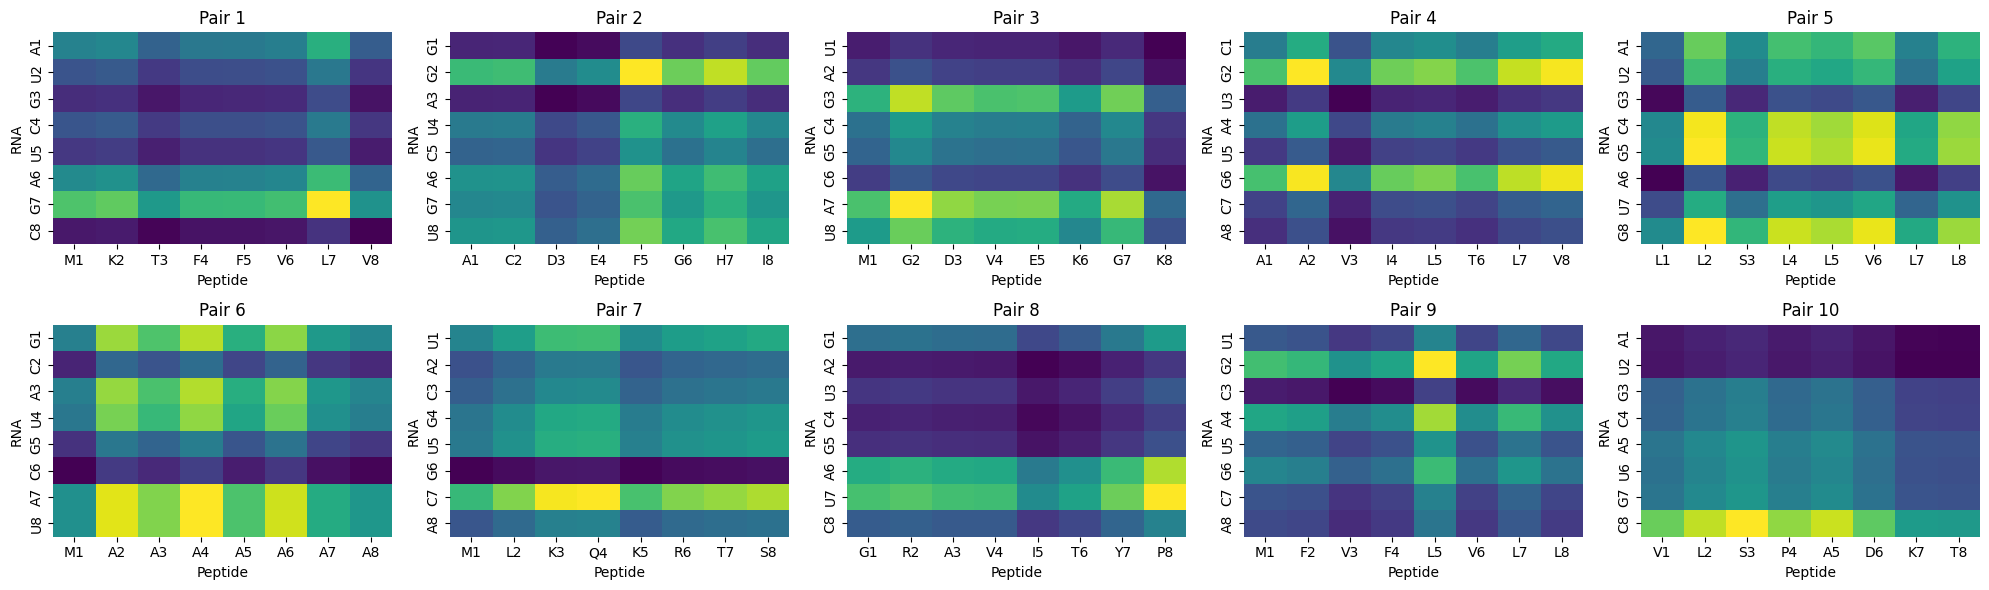

In [3]:
# ✅ Step 1: Setup
!pip install -q tensorflow plotly kaleido
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from google.colab import drive
from tensorflow.keras.models import load_model

# ✅ Step 2: Mount Drive and load model
drive.mount('/content/drive')
model = load_model('/content/drive/MyDrive/RNA-peptide/rna_peptide_dual_model_with_4486.keras')
print("✅ Model loaded")

# ✅ Step 3: Define vocab + encoder
rna_vocab = list("AUGC")
aa_vocab = list("ACDEFGHIKLMNPQRSTVWY")
rna_dict = {ch: i for i, ch in enumerate(rna_vocab)}
aa_dict = {ch: i for i, ch in enumerate(aa_vocab)}

def one_hot_encode(seq, vocab_dict, max_len):
    encoded = np.zeros((max_len, len(vocab_dict)))
    for i, ch in enumerate(seq[:max_len]):
        if ch in vocab_dict:
            encoded[i, vocab_dict[ch]] = 1
    return encoded

MAX_RNA_LEN = 100
MAX_PEP_LEN = 100

# ✅ Step 4: Load 10 prediction pairs from file
df_pred = pd.read_csv('/content/drive/MyDrive/RNA-peptide/predict.csv')
assert 'rna_seq' in df_pred.columns and 'protein_seq' in df_pred.columns

# ✅ Step 5: Define saliency function
def compute_saliency(rna_seq, pep_seq):
    rna_tensor = tf.convert_to_tensor(one_hot_encode(rna_seq, rna_dict, MAX_RNA_LEN).reshape(1, -1), dtype=tf.float32)
    pep_tensor = tf.convert_to_tensor(one_hot_encode(pep_seq, aa_dict, MAX_PEP_LEN).reshape(1, -1), dtype=tf.float32)

    rna_tensor = tf.Variable(rna_tensor)
    pep_tensor = tf.Variable(pep_tensor)

    with tf.GradientTape() as tape:
        tape.watch([rna_tensor, pep_tensor])
        preds = model([rna_tensor, pep_tensor])
    grads = tape.gradient(preds, [rna_tensor, pep_tensor])

    rna_grad = tf.abs(grads[0]).numpy().reshape(MAX_RNA_LEN, -1).sum(axis=1)
    pep_grad = tf.abs(grads[1]).numpy().reshape(MAX_PEP_LEN, -1).sum(axis=1)
    return rna_grad[:8], pep_grad[:8]

# ✅ Step 6: Generate static heatmap grid for all 10 pairs
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
for i, ax in enumerate(axes.flat):
    rna_seq = df_pred.loc[i, 'rna_seq']
    pep_seq = df_pred.loc[i, 'protein_seq']
    rna_sal, pep_sal = compute_saliency(rna_seq, pep_seq)
    heat = np.outer(rna_sal, pep_sal)

    rna_labels = [f"{ch}{j+1}" for j, ch in enumerate(rna_seq[:8])]
    pep_labels = [f"{ch}{j+1}" for j, ch in enumerate(pep_seq[:8])]

    sns.heatmap(heat, ax=ax, cmap="viridis", cbar=False, xticklabels=pep_labels, yticklabels=rna_labels)
    ax.set_title(f"Pair {i+1}")
    ax.set_xlabel("Peptide")
    ax.set_ylabel("RNA")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/RNA-peptide/all_saliency_heatmaps.png", dpi=300)
print("✅ Saved static heatmap grid")

# ✅ Step 7: Interactive plot for 1st pair
rna_seq = df_pred.loc[0, 'rna_seq']
pep_seq = df_pred.loc[0, 'protein_seq']
rna_sal, pep_sal = compute_saliency(rna_seq, pep_seq)
heat = np.outer(rna_sal, pep_sal)

rna_labels = [f"{ch}{j+1}" for j, ch in enumerate(rna_seq[:8])]
pep_labels = [f"{ch}{j+1}" for j, ch in enumerate(pep_seq[:8])]

fig = go.Figure(data=go.Heatmap(
    z=heat,
    x=pep_labels,
    y=rna_labels,
    colorscale='Viridis',
    hovertemplate='RNA: %{y}<br>Peptide: %{x}<br>Activation: %{z:.3f}<extra></extra>'
))
fig.update_layout(
    title="Saliency Heatmap (Pair 1)",
    xaxis_title="Peptide Bases",
    yaxis_title="RNA Bases",
    width=700,
    height=600
)
fig.write_html('/content/drive/MyDrive/RNA-peptide/interactive_saliency_heatmap.html')
print("✅ Saved interactive heatmap")
